Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [29]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
# from six.moves import cPickle as pickle
# from six.moves import range
import pickle
import os

In [30]:
data_path = '../../data/'
pickle_file = 'notMNIST.pickle'

with open(os.path.join(data_path, pickle_file), 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [31]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [32]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [33]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [34]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.572145
Minibatch accuracy: 6.2%
Validation accuracy: 10.7%
Minibatch loss at step 50: 1.524130
Minibatch accuracy: 31.2%
Validation accuracy: 50.4%
Minibatch loss at step 100: 1.310477
Minibatch accuracy: 75.0%
Validation accuracy: 70.8%
Minibatch loss at step 150: 0.440947
Minibatch accuracy: 93.8%
Validation accuracy: 77.8%
Minibatch loss at step 200: 0.844054
Minibatch accuracy: 75.0%
Validation accuracy: 73.6%
Minibatch loss at step 250: 1.017027
Minibatch accuracy: 75.0%
Validation accuracy: 77.5%
Minibatch loss at step 300: 0.749442
Minibatch accuracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 350: 0.373884
Minibatch accuracy: 87.5%
Validation accuracy: 79.5%
Minibatch loss at step 400: 1.007475
Minibatch accuracy: 75.0%
Validation accuracy: 79.9%
Minibatch loss at step 450: 0.643449
Minibatch accuracy: 75.0%
Validation accuracy: 80.6%
Minibatch loss at step 500: 1.376713
Minibatch accuracy: 68.8%
Validation accuracy: 81.0%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [42]:
image_size = 28 # image size
num_labels = 10 # labels
num_channels = 1 # channel'num
num_samples = 200000

patch_size = 5 # Filter size
depth = 16 # Filter num
num_hidden = 64 # Fully Connected Layer's units

# Params
lam = 0.01
n_epochs = 10
batch_size = 512

# learning rate（指数衰减法）
epochs_per_decay = 2 # 每epochs衰减learning_rate
initial_learning_rate = 0.008 # 初始learning_rate
learning_rate_decay_factor = 0.95 # 衰减系数

graph = tf.Graph()
with graph.as_default():

    # data
    tf_train_data = tf.placeholder(tf.float32, shape=([batch_size, image_size, image_size, num_channels]), name="images")
    tf_train_labels = tf.placeholder(tf.float32, shape=([batch_size, num_labels]), name="labels")
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)

    # Store layers weight & bias
    weights = {
        # 5x5 conv, 1 input, 16 outputs
        'wc1': tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1), name="w1"),
        # 5x5 conv, 16 inputs, 16 outputs
        'wc2': tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1), name="w2"),
        # fully connected, 7*7*64 inputs, 1024 outputs
        'wd1': tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1), name="w3"),
        # 1024 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name="w_out")
    }

    biases = {
        'bc1': tf.Variable(tf.zeros([depth]), name="b1"),
        'bc2': tf.Variable(tf.zeros([depth]), name="b2"),
        'bd1': tf.Variable(tf.zeros([num_hidden]), name="b3"),
        'out': tf.Variable(tf.zeros([num_labels]), name="b_out")
    }

    # dropout
    keep_pro = tf.placeholder(tf.float32, name='keep_pro')

    # Function
    def conv2d(x, W, b, strides=1):
        # Conv2D wrapper, with bias and relu activation
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x)

    def maxpool2d(x, k=2):
        # MaxPool2D wrapper
        return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')

    def conv_net(x, keep_pro):
        # Convolution Layer
        conv1 = conv2d(x, weights['wc1'], biases['bc1'])
        # Max Pooling (down-sampling)
        conv1 = maxpool2d(conv1, k=2)

        # Convolution Layer
        conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
        # Max Pooling (down-sampling)
        conv2 = maxpool2d(conv2, k=2)

        # Fully Connected layer
        # Reshape conv2 output to fit fully connected layer input
        fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.matmul(fc1, weights['wd1']) + biases['bd1']
        fc1 = tf.nn.relu(fc1)

        # dropout：改善过拟合
        fc1 = tf.nn.dropout(fc1, keep_pro)

        # Output
        out = tf.matmul(fc1, weights['out']) + biases['out']
        return out

    # output
    logits = conv_net(tf_train_data, keep_pro)

    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                          # lam * tf.nn.l2_loss(weights['wc1']) +
                          # lam * tf.nn.l2_loss(weights['wc2']) +
                          # lam * tf.nn.l2_loss(weights['wd1']) +
                          # lam * tf.nn.l2_loss(weights['out'])  # 正则项：改善过拟合
                          )

    # global step
    global_step = tf.Variable(0, name="global_step", trainable=False)

    # learning rate policy
    decay_steps = int(num_samples / batch_size * epochs_per_decay)
    learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                               global_step,
                                               decay_steps,
                                               learning_rate_decay_factor,
                                               staircase=True,
                                               name='exponential_decay_learning_rate')

    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    # Prediction
    train_prediction = tf.nn.softmax(logits)

    test_output = conv_net(tf_test_data, keep_pro)
    test_prediction = tf.nn.softmax(test_output)
    
    valid_output = conv_net(tf_valid_data, keep_pro)
    valid_prediction = tf.nn.softmax(valid_output)

In [43]:
# save loss
loss_array = []

with tf.Session(graph=graph) as sess:
    # Initializer
    sess.run(tf.global_variables_initializer())

    for epoch in range(n_epochs):
        total_batch = int(num_samples / batch_size)
        for step in range(total_batch):
            start = step * batch_size
            end = (step + 1) * batch_size
            batch_data, batch_labels = train_dataset[start:end,:,:,:], train_labels[start:end,:]

            # run session
            _, batch_loss, prediction = sess.run([optimizer, loss, train_prediction],
                                                 feed_dict={tf_train_data: batch_data,
                                                            tf_train_labels: batch_labels,
                                                            keep_pro: 0.75})

            if step % 20 == 0:
                print("Step:{}, loss:{}".format(step, batch_loss))
                print("Train prediction:{}".format(accuracy(prediction, batch_labels)))
                print("Valid prediction:{}".format(accuracy(valid_prediction.eval(
                    feed_dict={tf_train_data: batch_data, tf_train_labels: batch_labels, keep_pro: 1.0}
                ), valid_labels)))
                print("Test prediction:{}".format(accuracy(test_prediction.eval(
                    feed_dict={tf_train_data: batch_data, tf_train_labels: batch_labels, keep_pro: 1.0}
                ), test_labels)))

        loss_array.append(batch_loss)

Step:0, loss:2.3294692039489746
Train prediction:16.015625
Valid prediction:15.55
Test prediction:15.86
Step:20, loss:0.6847695112228394
Train prediction:80.859375
Valid prediction:81.1
Test prediction:87.94
Step:40, loss:0.5047612190246582
Train prediction:86.1328125
Valid prediction:84.32
Test prediction:90.95
Step:60, loss:0.4684596657752991
Train prediction:86.328125
Valid prediction:85.23
Test prediction:91.92
Step:80, loss:0.4470149874687195
Train prediction:87.5
Valid prediction:85.77
Test prediction:92.3
Step:100, loss:0.5251246094703674
Train prediction:86.1328125
Valid prediction:86.21
Test prediction:92.91
Step:120, loss:0.41591376066207886
Train prediction:87.5
Valid prediction:86.67
Test prediction:93.31
Step:140, loss:0.46997880935668945
Train prediction:85.546875
Valid prediction:87.07
Test prediction:93.55
Step:160, loss:0.4895389974117279
Train prediction:84.5703125
Valid prediction:87.1
Test prediction:93.39
Step:180, loss:0.3303981125354767
Train prediction:89.84375


Test prediction:95.52
Step:360, loss:0.2966621220111847
Train prediction:90.0390625
Valid prediction:90.44
Test prediction:95.65
Step:380, loss:0.4041855037212372
Train prediction:87.109375
Valid prediction:90.49
Test prediction:95.65
Step:0, loss:0.27766627073287964
Train prediction:90.625
Valid prediction:90.41
Test prediction:95.7
Step:20, loss:0.3266800045967102
Train prediction:90.4296875
Valid prediction:90.49
Test prediction:95.69
Step:40, loss:0.2565458416938782
Train prediction:91.796875
Valid prediction:90.16
Test prediction:95.81
Step:60, loss:0.293083131313324
Train prediction:92.3828125
Valid prediction:90.65
Test prediction:95.69
Step:80, loss:0.28052887320518494
Train prediction:90.8203125
Valid prediction:90.4
Test prediction:95.73
Step:100, loss:0.32013821601867676
Train prediction:90.4296875
Valid prediction:90.33
Test prediction:95.87
Step:120, loss:0.2666967213153839
Train prediction:92.578125
Valid prediction:90.4
Test prediction:95.72
Step:140, loss:0.349328398704

Valid prediction:90.61
Test prediction:96.08
Step:320, loss:0.27631741762161255
Train prediction:91.015625
Valid prediction:90.93
Test prediction:96.08
Step:340, loss:0.25257447361946106
Train prediction:91.2109375
Valid prediction:90.97
Test prediction:95.93
Step:360, loss:0.27540576457977295
Train prediction:91.796875
Valid prediction:90.69
Test prediction:96.03
Step:380, loss:0.41908568143844604
Train prediction:86.71875
Valid prediction:90.37
Test prediction:95.9
Step:0, loss:0.25074297189712524
Train prediction:93.359375
Valid prediction:90.79
Test prediction:95.94
Step:20, loss:0.25481006503105164
Train prediction:91.9921875
Valid prediction:90.83
Test prediction:96.03
Step:40, loss:0.2709658741950989
Train prediction:92.1875
Valid prediction:90.94
Test prediction:95.92
Step:60, loss:0.28851017355918884
Train prediction:92.1875
Valid prediction:90.66
Test prediction:95.92
Step:80, loss:0.2743178606033325
Train prediction:91.796875
Valid prediction:90.7
Test prediction:95.77
Step:

W0923 11:04:42.709559  6412 legend.py:1289] No handles with labels found to put in legend.


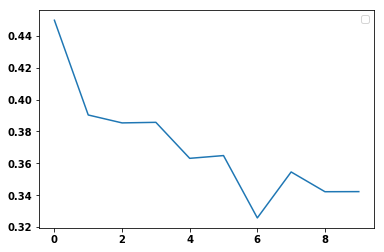

In [45]:
# 可视化loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(range(n_epochs)), np.array(loss_array))
plt.legend()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [48]:
image_size = 28 # image size
num_labels = 10 # labels
num_channels = 1 # channel'num
num_samples = 200000

patch_size = 5 # Filter size
depth_1 = 6 # Filter num
depth_2 = 16
depth_3 = 120
num_hidden = 84 # Fully Connected Layer's units

# Params
lam = 0.01
n_epochs = 10
batch_size = 512

# learning rate（指数衰减法）
epochs_per_decay = 2 # 每epochs衰减learning_rate
initial_learning_rate = 0.008 # 初始learning_rate
learning_rate_decay_factor = 0.95 # 衰减系数

graph = tf.Graph()
with graph.as_default():

    # data
    tf_train_data = tf.placeholder(tf.float32, shape=([batch_size, image_size, image_size, num_channels]), name="images")
    tf_train_labels = tf.placeholder(tf.float32, shape=([batch_size, num_labels]), name="labels")
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)

    # Store layers weight & bias
    weights = {
        # 5x5 conv, 1 input, 6 outputs
        'wc1': tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1), name="w1"),
        # 5x5 conv, 6 inputs, 16 outputs
        'wc2': tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_2], stddev=0.1), name="w2"),
         # 5x5 conv, 16 inputs, 120 outputs
        'wc3': tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_3], stddev=0.1), name="w3"),
        # fully connected, 7*7*64 inputs, 1024 outputs
        'wd1': tf.Variable(tf.truncated_normal([1 * 1 * depth_3, num_hidden], stddev=0.1), name="wd"),
        # 1024 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name="w_out")
    }

    biases = {
        'bc1': tf.Variable(tf.zeros([depth_1]), name="b1"),
        'bc2': tf.Variable(tf.zeros([depth_2]), name="b2"),
        'bc3': tf.Variable(tf.zeros([depth_3]), name="b3"),
        'bd1': tf.Variable(tf.zeros([num_hidden]), name="bd"),
        'out': tf.Variable(tf.zeros([num_labels]), name="b_out")
    }

    # dropout
    keep_pro = tf.placeholder(tf.float32, name='keep_pro')

    # Function
    def conv2d(x, W, b, strides=1, padding='SAME'):
        # Conv2D wrapper, with bias and relu activation
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x)

    def maxpool2d(x, k=2, padding='SAME'):
        # MaxPool2D wrapper
        return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding=padding)

    def conv_net(x, keep_pro):
        # Convolution Layer 1
        conv1 = conv2d(x, weights['wc1'], biases['bc1'], padding='SAME')
        # Max Pooling (down-sampling)
        conv1 = maxpool2d(conv1, k=2, padding='SAME')

        # Convolution Layer 2
        conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], padding='VALID')
        # Max Pooling (down-sampling)
        conv2 = maxpool2d(conv2, k=2, padding='SAME')
        
        # Convolution Layer 3
        conv3 = conv2d(conv2, weights['wc3'], biases['bc3'], padding='VALID')

        # Fully Connected layer
        # Reshape conv2 output to fit fully connected layer input
        fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.matmul(fc1, weights['wd1']) + biases['bd1']
        fc1 = tf.nn.relu(fc1)

        # dropout：改善过拟合
        fc1 = tf.nn.dropout(fc1, keep_pro)

        # Output
        out = tf.matmul(fc1, weights['out']) + biases['out']
        return out

    # output
    logits = conv_net(tf_train_data, keep_pro)

    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                          # lam * tf.nn.l2_loss(weights['wc1']) +
                          # lam * tf.nn.l2_loss(weights['wc2']) +
                          # lam * tf.nn.l2_loss(weights['wd1']) +
                          # lam * tf.nn.l2_loss(weights['out'])  # 正则项：改善过拟合
                          )

    # global step
    global_step = tf.Variable(0, name="global_step", trainable=False)

    # learning rate policy
    decay_steps = int(num_samples / batch_size * epochs_per_decay)
    learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                               global_step,
                                               decay_steps,
                                               learning_rate_decay_factor,
                                               staircase=True,
                                               name='exponential_decay_learning_rate')

    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    # Prediction
    train_prediction = tf.nn.softmax(logits)

    test_output = conv_net(tf_test_data, keep_pro)
    test_prediction = tf.nn.softmax(test_output)
    
    valid_output = conv_net(tf_valid_data, keep_pro)
    valid_prediction = tf.nn.softmax(valid_output)

In [49]:
# save loss
loss_array = []

with tf.Session(graph=graph) as sess:
    # Initializer
    sess.run(tf.global_variables_initializer())

    for epoch in range(n_epochs):
        total_batch = int(num_samples / batch_size)
        for step in range(total_batch):
            start = step * batch_size
            end = (step + 1) * batch_size
            batch_data, batch_labels = train_dataset[start:end,:,:,:], train_labels[start:end,:]

            # run session
            _, batch_loss, prediction = sess.run([optimizer, loss, train_prediction],
                                                 feed_dict={tf_train_data: batch_data,
                                                            tf_train_labels: batch_labels,
                                                            keep_pro: 0.75})

            if step % 20 == 0:
                print("Step:{}, loss:{}".format(step, batch_loss))
                print("Train prediction:{}".format(accuracy(prediction, batch_labels)))
                print("Valid prediction:{}".format(accuracy(valid_prediction.eval(
                    feed_dict={tf_train_data: batch_data, tf_train_labels: batch_labels, keep_pro: 1.0}
                ), valid_labels)))
                print("Test prediction:{}".format(accuracy(test_prediction.eval(
                    feed_dict={tf_train_data: batch_data, tf_train_labels: batch_labels, keep_pro: 1.0}
                ), test_labels)))

        loss_array.append(batch_loss)

Step:0, loss:2.314842700958252
Train prediction:11.9140625
Valid prediction:23.94
Test prediction:25.95
Step:20, loss:0.7306785583496094
Train prediction:77.9296875
Valid prediction:79.54
Test prediction:86.28
Step:40, loss:0.4639003574848175
Train prediction:87.3046875
Valid prediction:83.32
Test prediction:90.11
Step:60, loss:0.46597668528556824
Train prediction:86.9140625
Valid prediction:84.53
Test prediction:91.17
Step:80, loss:0.4338417649269104
Train prediction:88.0859375
Valid prediction:85.56
Test prediction:91.84
Step:100, loss:0.4984356462955475
Train prediction:87.109375
Valid prediction:85.93
Test prediction:92.31
Step:120, loss:0.40820416808128357
Train prediction:88.4765625
Valid prediction:87.35
Test prediction:93.16
Step:140, loss:0.4719412326812744
Train prediction:84.765625
Valid prediction:87.14
Test prediction:93.15
Step:160, loss:0.4141617715358734
Train prediction:88.28125
Valid prediction:87.42
Test prediction:93.68
Step:180, loss:0.3282180726528168
Train predic

Valid prediction:90.37
Test prediction:95.5
Step:360, loss:0.2329525649547577
Train prediction:92.3828125
Valid prediction:90.3
Test prediction:95.7
Step:380, loss:0.41190463304519653
Train prediction:86.71875
Valid prediction:90.42
Test prediction:95.56
Step:0, loss:0.2540034353733063
Train prediction:91.40625
Valid prediction:90.2
Test prediction:95.35
Step:20, loss:0.27186983823776245
Train prediction:91.2109375
Valid prediction:90.17
Test prediction:95.48
Step:40, loss:0.23917952179908752
Train prediction:91.796875
Valid prediction:90.7
Test prediction:95.84
Step:60, loss:0.2530757188796997
Train prediction:92.3828125
Valid prediction:90.5
Test prediction:95.65
Step:80, loss:0.25656992197036743
Train prediction:91.9921875
Valid prediction:90.58
Test prediction:95.56
Step:100, loss:0.32097581028938293
Train prediction:89.0625
Valid prediction:90.07
Test prediction:95.33
Step:120, loss:0.2595524787902832
Train prediction:92.3828125
Valid prediction:90.29
Test prediction:95.5
Step:140

Step:300, loss:0.24132849276065826
Train prediction:91.40625
Valid prediction:90.81
Test prediction:95.81
Step:320, loss:0.2652839720249176
Train prediction:91.796875
Valid prediction:90.67
Test prediction:95.89
Step:340, loss:0.2637340724468231
Train prediction:91.6015625
Valid prediction:90.55
Test prediction:95.78
Step:360, loss:0.2112874537706375
Train prediction:93.1640625
Valid prediction:90.25
Test prediction:95.74
Step:380, loss:0.35433194041252136
Train prediction:89.2578125
Valid prediction:90.6
Test prediction:95.82
Step:0, loss:0.24671533703804016
Train prediction:91.2109375
Valid prediction:90.82
Test prediction:95.78
Step:20, loss:0.24279999732971191
Train prediction:92.1875
Valid prediction:90.54
Test prediction:95.69
Step:40, loss:0.1881858855485916
Train prediction:92.7734375
Valid prediction:90.96
Test prediction:96.02
Step:60, loss:0.21876323223114014
Train prediction:93.5546875
Valid prediction:90.83
Test prediction:95.83
Step:80, loss:0.2764732241630554
Train predi

W0923 11:49:12.805558  6412 legend.py:1289] No handles with labels found to put in legend.


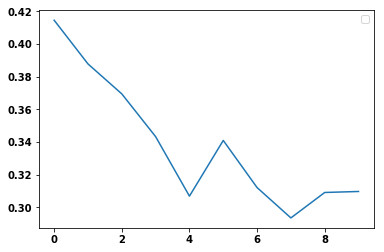

In [50]:
# 可视化loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(range(n_epochs)), np.array(loss_array))
plt.legend()